In [109]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import geopandas as gpd
import json
import warnings
import time
from os import listdir
from os.path import isfile,join
import datetime
from branca.element import MacroElement
from matplotlib.colors import rgb2hex
from jinja2 import Template
import folium
from branca.colormap import LinearColormap
import matplotlib
import matplotlib.ticker as ticker
import requests
from sklearn.metrics import r2_score
import catboost

In [110]:
def get_covid_data(info='cases'):
    if info == 'cases':
        url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
               'csse_covid_19_time_series/time_series_covid19_confirmed_US.csv').format(sep=2*'\n')
        ren_col = 'Total_cases'
        val_col = 'Daily_cases'
    if info =='deaths':
            url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
                    'csse_covid_19_time_series/time_series_covid19_deaths_US.csv').format(sep=2*'\n')
            ren_col = 'Total_deaths'
            val_col = 'Daily_deaths'
    df = pd.read_csv(url)
    df = df[df['iso3']=='USA']
    df = df.dropna(subset = ['FIPS'])
    df = df[df.FIPS <= 56045]

    df.FIPS = df.FIPS.astype(int).astype(str).str.zfill(5)
    df = df[(df.Admin2 != 'Unassigned' ) & (df.Admin2.notna() )]
    df = df.drop(columns= ['UID','iso2', 'iso3', 'code3','Country_Region','Combined_Key' ])
    date_cols = [col for col in df.columns if '/20' in col]
    id_cols = [col for col in df.columns if col not in date_cols]
    df_gr = df.melt(id_vars=id_cols,value_vars=date_cols)
    df_gr[val_col] = df_gr.groupby(['FIPS'])[['value']].diff().fillna(0)
    df_gr = df_gr.rename(columns = {'value':ren_col, 'variable':'date', 
                                    'Long_':'Lng', 'Admin2':'COUNTY', 
                                   'Province_State': 'STATE', 'FIPS':'fips'})
    df_gr.date = pd.to_datetime( df_gr.date, infer_datetime_format=True)
    df_gr = df_gr.drop(columns = ['STATE', 'COUNTY'])
    return df_gr
    

In [111]:
df_covid_cases = get_covid_data(info='cases')
df_covid_deaths = get_covid_data(info='deaths')[['fips','date','Total_deaths','Daily_deaths']]
df_covid = pd.merge(left = df_covid_cases, right = df_covid_deaths, on = ['fips', 'date'])
df_covid

,fips,Lat,Lng,date,Total_cases,Daily_cases,Total_deaths,Daily_deaths
0,01001,32.539527,-86.644082,2020-01-22,0,0.0,0,0.0
1,01003,30.727750,-87.722071,2020-01-22,0,0.0,0,0.0
2,01005,31.868263,-85.387129,2020-01-22,0,0.0,0,0.0
3,01007,32.996421,-87.125115,2020-01-22,0,0.0,0,0.0
4,01009,33.982109,-86.567906,2020-01-22,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...
574981,56037,41.659439,-108.882788,2020-07-22,201,7.0,0,0.0
574982,56039,43.935225,-110.589080,2020-07-22,234,8.0,0,0.0
574983,56041,41.287818,-110.547578,2020-07-22,224,1.0,0,0.0
574984,56043,43.904516,-107.680187,2020-07-22,45,1.0,0,0.0


In [4]:
def get_mobility_data(rolling_mean=False):
    mob_index_url = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv'
    
    df_mobility_index = pd.read_csv(mob_index_url, parse_dates=['date'])
    df_mobility_index = df_mobility_index.dropna(subset=['fips','admin2'])
    df_mobility_index.fips = df_mobility_index.fips.astype(int)
    df_mobility_index.fips = df_mobility_index.fips.astype(str).str.zfill(5)
    df_mobility_index = df_mobility_index.rename(columns={'admin1':'STATE','admin2':'COUNTY' })
    df_mobility_index = df_mobility_index.drop(columns = ['country_code', 'admin_level'])
    
    if rolling_mean:
        mob_col= ['m50']
        m50 = df_mobility_index.groupby(['fips','date'])[mob_col].mean()
        m50['rolling_mean_mob'] = m50[mob_col].rolling(7,min_periods=1).mean()
        m50 = m50.reset_index()
        return m50
    
    return df_mobility_index

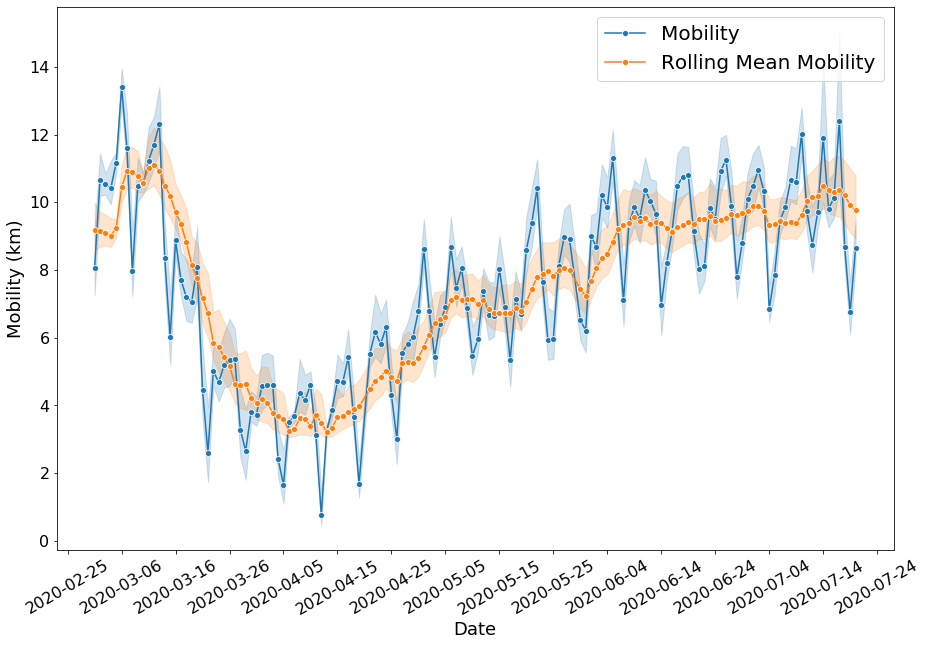

In [112]:
df_mobility = get_mobility_data()
df_mobility_rm = get_mobility_data(rolling_mean=True)
plt.figure(figsize=(15,10))
sns.lineplot(x='date', y = 'm50', data=df_mobility, marker='o',ci=99,label = 'Mobility')
sns.lineplot(x='date', y = 'rolling_mean_mob', data=df_mobility_rm, marker='o',ci=99, label = 'Rolling Mean Mobility')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Mobility (km)', fontsize = 18)
plt.xticks(fontsize=16, rotation=30)
plt.yticks(fontsize=16)
plt.legend(fontsize = 20)
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

In [113]:
df_mobility

,date,STATE,COUNTY,fips,samples,m50,m50_index
140,2020-03-01,Alabama,Autauga County,01001,1703,7.194,49
141,2020-03-02,Alabama,Autauga County,01001,1829,14.587,100
142,2020-03-03,Alabama,Autauga County,01001,1840,13.865,95
143,2020-03-04,Alabama,Autauga County,01001,1900,13.880,95
144,2020-03-05,Alabama,Autauga County,01001,1825,14.659,100
...,...,...,...,...,...,...,...
378022,2020-07-16,Wyoming,Uinta County,56041,760,6.832,218
378023,2020-07-17,Wyoming,Uinta County,56041,841,4.705,150
378024,2020-07-18,Wyoming,Uinta County,56041,833,14.370,458
378025,2020-07-19,Wyoming,Uinta County,56041,990,14.429,460


In [114]:
# Importing County Level spending data from https://github.com/Opportunitylab/EconomicTracker
county_spending_url =  'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/Affinity%20-%20County%20-%20Weekly.csv'
df_county_spending = pd.read_csv(county_spending_url)

df_county_spending['date'] = df_county_spending['year'].astype(str) + '-' + \
                            df_county_spending['month'].astype(str) + '-' + \
                            df_county_spending['day_endofweek'].astype(str)
df_county_spending.date = pd.to_datetime(df_county_spending.date, infer_datetime_format=True)
df_county_spending.countyfips = df_county_spending.countyfips.astype(int)
df_county_spending.countyfips = df_county_spending.countyfips.astype(str).str.zfill(5)
df_county_spending = df_county_spending.rename(columns={'countyfips':'fips'})
print(df_county_spending.fips.nunique())

df_county_spending

1774


,year,month,day_endofweek,fips,spend_all,date
0,2020,1,12,01001,-0.0831,2020-01-12
1,2020,1,12,01003,-0.0036,2020-01-12
2,2020,1,12,01009,0.0303,2020-01-12
3,2020,1,12,01015,0.0156,2020-01-12
4,2020,1,12,01019,-0.0812,2020-01-12
...,...,...,...,...,...,...
47893,2020,7,12,56037,0.0213,2020-07-12
47894,2020,7,12,56039,-0.0138,2020-07-12
47895,2020,7,12,56041,-0.1330,2020-07-12
47896,2020,7,12,56043,0.0874,2020-07-12


(737485.0, 737626.0)

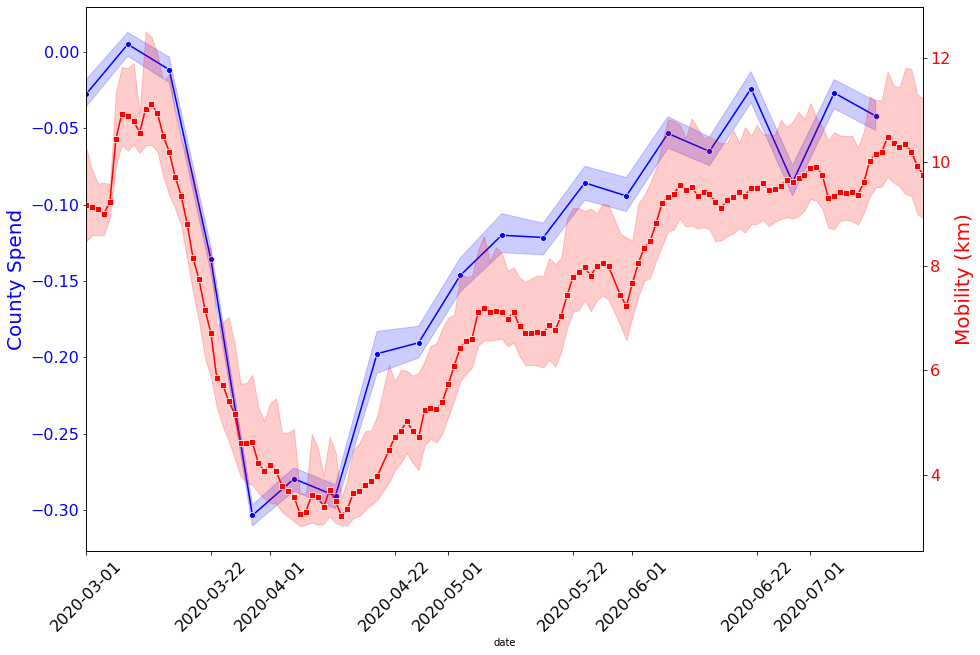

In [115]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(x='date', y = 'spend_all', data=df_county_spending, marker='o',ci=100,color='blue')
plt.ylabel('County Spend', color='blue', fontsize=20)
plt.xticks(fontsize=16,rotation=45)
plt.yticks(fontsize=16,color='blue')
ax2 = ax.twinx()
sns.lineplot(x='date', y = 'rolling_mean_mob', data=df_mobility_rm, marker='s',ci=100, ax =ax2, color = 'red')
plt.ylabel('Mobility (km)',color='red', fontsize=20)
plt.yticks(fontsize=16,color='red')
plt.xlim(df_mobility_rm.date.min(), df_mobility_rm.date.max())

In [117]:
def get_covid_rates():
    case_url = 'https://github.com/OpportunityInsights/EconomicTracker/blob/main/data/COVID%20Cases%20-%20County%20-%20Daily.csv?raw=true'
    death_url = 'https://github.com/OpportunityInsights/EconomicTracker/blob/main/data/COVID%20Deaths%20-%20County%20-%20Daily.csv?raw=true'
    df_covid_case_rate = pd.read_csv(case_url,low_memory=False)
    df_covid_death_rate = pd.read_csv(death_url,low_memory=False)
    df_covid_rate = pd.DataFrame()
    for df in [df_covid_case_rate,df_covid_death_rate]:
        df['date'] = df['year'].astype(str) + '-' + \
                            df['month'].astype(str) + '-' + \
                            df['day'].astype(str)
        df.date = pd.to_datetime(df.date, infer_datetime_format=True)
        df.countyfips = df.countyfips.astype(int)
        df.countyfips = df.countyfips.astype(str).str.zfill(5)
        df = df.rename(columns={'countyfips':'fips'})
        df = df.drop(columns=['month','day','year'])
        cols = list(df.columns[1:3])
        if 'death_rate' in cols:
            
            df = df.drop(columns=['fips','date'])
        for col in cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(0)
        df_covid_rate = pd.concat([df_covid_rate,df], axis =1)
    return df_covid_rate
    

In [118]:
df_covid_rate = get_covid_rates()
df_covid_rate

,fips,case_rate,new_case_rate,date,death_rate,new_death_rate
0,01001,0.0,0.00,2020-01-21,0.00,0.000
1,01003,0.0,0.00,2020-01-21,0.00,0.000
2,01005,0.0,0.00,2020-01-21,0.00,0.000
3,01007,0.0,0.00,2020-01-21,0.00,0.000
4,01009,0.0,0.00,2020-01-21,0.00,0.000
...,...,...,...,...,...,...
574981,56037,458.0,12.80,2020-07-21,4.72,0.337
574982,56039,963.0,37.70,2020-07-21,4.26,0.000
574983,56041,1103.0,10.60,2020-07-21,0.00,0.000
574984,56043,551.0,1.83,2020-07-21,64.10,0.000


In [119]:
df_covid = pd.merge(left = df_covid, right = df_covid_rate, on = ['fips', 'date'], how='outer')
df_mob_covid = pd.merge(left = df_mobility, right = df_covid, on = ['fips', 'date'], how='outer')
df_mob_covid['Weekday'] = df_mob_covid.date.dt.day_name()
df_mob_covid = df_mob_covid.dropna(subset=['Lat'])
fips_lat_lng = df_mob_covid[['fips','Lat','Lng']].drop_duplicates().set_index('fips').to_dict('index')

In [120]:
# Get API keys from config file
def get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY):
    
    url = 'https://api.worldweatheronline.com/premium/v1/past-weather.ashx'
    query = '?q=' + str(lat) + ','+str(lng)
    key = '&key=' + API_KEY
    ret_format = '&format=json'
    sdate = '&enddate='+ start_dt
    edate = '&date=' + end_dt
    tp = '&tp=24'
    final_url = url + query + ret_format +  edate + sdate + tp + key
    get_weather = requests.get(final_url)
    weather_data = json.loads(get_weather.text)
    
    #df = pd.DataFrame(weather_data['data']['weather'])
    return weather_data

def get_weather_data(lat,lng, start_date,end_date,fips,key_count):
    new_low = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    new_end = datetime.timedelta(days=34) + new_low
    final_end = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    df = pd.DataFrame()
    API_KEYS = list_of_API_KEYS
    last=False
    API_KEY=API_KEYS[key_count]
    #key_count=0
    while(last==False):
        if new_end <final_end:
            
            end_dt = datetime.datetime.strftime(new_low,'%Y-%m-%d' )
            start_dt = datetime.datetime.strftime(new_end,'%Y-%m-%d' )
            
            weather_data = get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY)
            while( 'error' in weather_data['data']):
                
                print('Error', API_KEY)
                    
            
                key_count+=1
                if key_count == len(API_KEYS):
                    raise Exception('Out of API Keys')
                API_KEY=API_KEYS[key_count]
                weather_data = get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY)
            df_weather_chunk = pd.DataFrame(weather_data['data']['weather'])
            df = pd.concat([df,df_weather_chunk], ignore_index=True)
            new_low = new_end + datetime.timedelta(days=1)
            last_itr = new_end
            new_end = datetime.timedelta(days=34) + new_low

           
        else:
            new_low = last_itr + datetime.timedelta(days=1)
            new_end = final_end
            end_dt = datetime.datetime.strftime(new_low,'%Y-%m-%d' )
            start_dt = datetime.datetime.strftime(new_end,'%Y-%m-%d' )
            weather_data = get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY)
            df_weather_chunk = pd.DataFrame(weather_data['data']['weather'])
            df = pd.concat([df,df_weather_chunk], ignore_index=True)
            last = True

    df = df.drop(columns=['uvIndex'])
    df_h = pd.DataFrame()
    
    for val in df['hourly'].values:
        df_h = pd.concat([df_h, pd.DataFrame(val)], ignore_index=True)
    
    df = pd.concat([df, df_h], axis=1)
    use_cols = ['date','tempC', 'maxtempC', 'mintempC','WindChillC','FeelsLikeC', 'visibilityMiles','HeatIndexC', 
            'avgtempC', 'windspeedMiles', 'winddirDegree','pressure', 'WindGustMiles','precipMM',
            'totalSnow_cm' , 'sunHour', 'DewPointC','humidity','uvIndex']
    df = df[use_cols]
    cols= [col for col in df.columns if col!='date']
    df= df.apply(pd.to_numeric, errors='ignore')
    df.date = pd.to_datetime(df.date, infer_datetime_format=True)
    df['fips'] = fips
    return df,key_count

In [121]:
start_date = datetime.datetime.strftime(df_mob_covid.date.max(), '%Y-%m-%d')
end_date =  datetime.datetime.strftime(df_mob_covid.date.min(), '%Y-%m-%d')

fpath1 = './Data/Weather_Files/'
os.makedirs(fpath1, exist_ok=True)
files_all = [fpath1+f for f in listdir(fpath1) if isfile(join(fpath1, f))]
weather_files = [f for f in files_all if 'Weather' in f]
fips_done = [file.split('_')[3].split('.csv')[0] for file in weather_files]
key_count = 0
for fips,lat_lng in list(fips_lat_lng.items()):
    if fips in fips_done:
        
        continue
    else:
        
        lat,lng = lat_lng['Lat'],lat_lng['Lng']
        weather_df,key_count = get_weather_data(lat,lng, start_date,end_date,fips,key_count)
        weather_df.to_csv(fpath1 + 'Weather_FIPS_'+str(fips)+'.csv',index=False)

fpath1 = './Data/Weather_Files/'
files_all = [fpath1+f for f in listdir(fpath1) if isfile(join(fpath1, f))]
weather_files = [f for f in files_all if 'Weather' in f]
fips_done = [file.split('_')[3].split('.csv')[0] for file in weather_files]

df_weather = pd.DataFrame()
i=0
for file in weather_files:
    df = pd.read_csv(file)
    df_weather = pd.concat([df_weather,df], ignore_index=True)
    i+=1
    if i%300 == 0:
        print('Finised Records', i)
df_weather.date = pd.to_datetime(df_weather.date, infer_datetime_format=True)
df_weather.to_csv('./Data/All_County_Weather_'+start_date+'.csv', index=False)
df_weather

In [122]:
df_weather  = pd.read_csv('./Data/All_County_Weather_2020-07-19.csv', parse_dates=['date'])
df_weather

,date,tempC,maxtempC,mintempC,WindChillC,FeelsLikeC,visibilityMiles,HeatIndexC,avgtempC,windspeedMiles,winddirDegree,pressure,WindGustMiles,precipMM,totalSnow_cm,sunHour,DewPointC,humidity,uvIndex,fips
0,2020-01-22,8,8,-2,0,0,6,3,4,5,105,1028,9,0.0,0.0,6.9,-8,49,1,1001
1,2020-01-23,8,8,2,3,3,3,5,5,8,96,1020,12,34.5,0.0,5.3,3,86,1,1001
2,2020-01-24,14,14,7,10,10,5,11,12,7,268,1016,11,17.2,0.0,10.0,8,82,4,1001
3,2020-01-25,11,11,2,4,4,6,6,7,6,293,1021,9,0.0,0.0,10.0,2,76,3,1001
4,2020-01-26,11,11,4,7,7,6,7,8,2,136,1020,4,0.1,0.0,6.9,4,78,2,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565555,2020-07-15,24,24,9,16,16,6,17,18,6,220,1014,8,0.7,0.0,14.5,7,58,5,56045
565556,2020-07-16,28,28,13,21,21,6,21,23,6,186,1012,9,0.3,0.0,14.5,6,42,6,56045
565557,2020-07-17,31,31,17,24,24,6,24,26,7,275,1007,11,0.0,0.0,14.5,7,42,7,56045
565558,2020-07-18,24,24,14,20,20,6,21,20,9,251,1011,12,0.0,0.0,14.5,8,48,6,56045


In [123]:
df_weather.fips = df_weather.fips.astype(str).str.zfill(5)
df_mob_covid_weather = pd.merge(left = df_mob_covid, right = df_weather, on =['date', 'fips'])
df_mob_covid_weather

,date,STATE,COUNTY,fips,samples,m50,m50_index,Lat,Lng,Total_cases,...,windspeedMiles,winddirDegree,pressure,WindGustMiles,precipMM,totalSnow_cm,sunHour,DewPointC,humidity,uvIndex
0,2020-03-01,Alabama,Autauga County,01001,1703.0,7.194,49.0,32.539527,-86.644082,0.0,...,6,193,1023,10,0.0,0.0,11.3,6,68,4
1,2020-03-02,Alabama,Autauga County,01001,1829.0,14.587,100.0,32.539527,-86.644082,0.0,...,7,188,1016,12,21.4,0.0,5.7,12,88,3
2,2020-03-03,Alabama,Autauga County,01001,1840.0,13.865,95.0,32.539527,-86.644082,0.0,...,7,247,1012,12,24.5,0.0,5.7,17,93,4
3,2020-03-04,Alabama,Autauga County,01001,1900.0,13.880,95.0,32.539527,-86.644082,0.0,...,9,28,1014,15,75.7,0.0,5.7,13,94,3
4,2020-03-05,Alabama,Autauga County,01001,1825.0,14.659,100.0,32.539527,-86.644082,0.0,...,10,143,1015,16,16.2,0.0,5.7,10,92,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565555,2020-07-19,NaN,NaN,56011,NaN,NaN,NaN,44.588551,-104.569771,9.0,...,7,93,1014,10,4.5,0.0,10.4,9,51,5
565556,2020-07-19,NaN,NaN,56017,NaN,NaN,NaN,43.719307,-108.442317,14.0,...,7,139,1013,10,0.0,0.0,14.5,3,30,7
565557,2020-07-19,NaN,NaN,56027,NaN,NaN,NaN,43.056077,-104.475890,2.0,...,11,119,1013,15,3.4,0.0,13.5,12,52,6
565558,2020-07-19,NaN,NaN,56043,NaN,NaN,NaN,43.904516,-107.680187,44.0,...,6,139,1013,9,0.0,0.0,14.5,4,28,7


In [124]:
df_county = pd.read_csv('./Data/nhgis0010_ds239_20185_2018_county.csv', encoding='latin')
df_county['fips'] = df_county.STATEA.astype(str).str.zfill(2)+df_county.COUNTYA.astype(str).str.zfill(3)
df_gini_income = pd.read_csv('./Data/nhgis0010_ds240_20185_2018_county.csv', encoding='latin')
df_gini_income = df_gini_income[['STATE', 'COUNTY', 'AKGVE001']]
df_county_demo = pd.merge(left = df_county , right = df_gini_income, on =['STATE', 'COUNTY'])
cols_A = df_county_demo.columns[df_county_demo.columns.str.endswith('A')]
margin_cols = [col for col in df_county_demo.columns if 'M' in col[4:5]]

df_county_demo = df_county_demo.drop(columns = ['GISJOIN']+list(cols_A) + margin_cols )
df_county_demo.head(2)

,YEAR,STATE,COUNTY,NAME_E,AJWBE001,AJWBE002,AJWBE003,AJWBE004,AJWBE005,AJWBE006,...,AJ35E060,AJ35E061,AJ35E062,AJ35E063,AJ35E064,AJ35E065,AJ35E066,NAME_M,fips,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,26874,1789,2021,1754,1256,...,1310,1387,455,0,32,2458,0,"Autauga County, Alabama",01001,0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,101188,5855,5551,7544,4134,...,7046,8078,1462,4,760,9752,162,"Baldwin County, Alabama",01003,0.4609


In [125]:
import re
f = open('./Data/nhgis0010_ds239_20185_2018_county_codebook.txt','r') 
searchlines = f.readlines()
f.close()
for i in range(len(searchlines)):
    if '    Margins of error' in searchlines[i] :
        error_margin = i
col_dict={}
for col in df_county_demo.columns[4:]:
    for i, line in enumerate(searchlines):
        #print(i)
        if col[:-4] in line and 'Table' in searchlines[i-3] and i <error_margin :
            text = re.sub(r"\s+", " ", searchlines[i-3].strip())
            top_col = text.split(':')[1].strip()
        if col in line:
            text = line.strip().split(':')[1:]
            col_name = ''.join(map(str, text))
            col_name = re.sub(r"\s+", " ", col_name).strip()
            #print(col_name)
            col_dict[col] = top_col+ '_' + col_name
        
df_county_demo = df_county_demo.rename(columns=col_dict)
insurance_cols = [col for col in df_county_demo.columns if 'Insurance' in col]
hispanic_cols = [col for col in df_county_demo.columns if 'Hispanic' in col]

df_county_demo = df_county_demo.drop(columns=insurance_cols+hispanic_cols)
df_county_demo.head(2)

,YEAR,STATE,COUNTY,NAME_E,Sex by Age_Total,Sex by Age_Male,Sex by Age_Male Under 5 years,Sex by Age_Male 5 to 9 years,Sex by Age_Male 10 to 14 years,Sex by Age_Male 15 to 17 years,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_15.0 to 19.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,fips,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,26874,1789,2021,1754,1256,...,475.0,725.0,339.0,393.0,194.0,336.0,1509.0,718.0,01001,0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,101188,5855,5551,7544,4134,...,2390.0,2221.0,2183.0,1775.0,1516.0,1336.0,3961.0,2961.0,01003,0.4609


In [126]:
county_election = pd.read_csv('./Data/countypres_2000-2016.csv', sep = '\t')
county_election = county_election[county_election.year ==2016]
maj_party = county_election['party'][county_election.groupby('FIPS')['candidatevotes'].idxmax()]
fips = county_election['FIPS'][county_election.groupby('FIPS')['candidatevotes'].idxmax()]
fips_party = pd.concat([fips,maj_party], ignore_index=False,axis=1,).reset_index(drop=True).dropna()
fips_idx_county = county_election.set_index('FIPS')
pct_rep = (fips_idx_county[fips_idx_county['party']=='republican']['candidatevotes'])/ \
            (fips_idx_county[fips_idx_county['party']=='republican']['candidatevotes']+fips_idx_county[fips_idx_county['party']=='democrat']['candidatevotes'])
pct_rep = pct_rep.reset_index().rename(columns={'candidatevotes': 'pct_republican'})
fips_party = fips_party.join(pct_rep.set_index('FIPS'), on = 'FIPS')
fips_party.FIPS = fips_party.FIPS.astype(int).astype(str).str.zfill(5)
fips_party

,FIPS,party,pct_republican
0,01001,republican,0.753775
1,01003,republican,0.797922
2,01005,republican,0.528232
3,01007,republican,0.782397
4,01009,republican,0.913812
...,...,...,...
3150,56037,republican,0.789990
3151,56039,democrat,0.348999
3152,56041,republican,0.836596
3153,56043,republican,0.845484


In [127]:
total_cols = [col for col in df_county_demo.columns if 'Total' in col]
for col in total_cols:
    remaining_cols = [c for c in list(df_county_demo.columns) if c!=col]
    for df_col in remaining_cols:
        if col.split('_')[0] in df_col:
            df_county_demo[df_col] = df_county_demo[df_col]/df_county_demo[col]
df_county_demo = df_county_demo.join(fips_party.set_index('FIPS'), on = 'fips')  
df_county_demo.isna().sum()

YEAR                                                                                   0
STATE                                                                                  0
COUNTY                                                                                 0
NAME_E                                                                                 0
Sex by Age_Total                                                                       0
                                                                                    ... 
Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed      1
fips                                                                                   0
AKGVE001                                                                               1
party                                                                                106
pct_republican                                                                       106
Length: 150, dtype: i

In [128]:
df_all = pd.merge(left = df_mob_covid_weather.drop(columns=['STATE', 'COUNTY']), right = df_county_demo, on = ['fips'])
# Removing the dates before March 1 for mobility predictions
df_all_mob = df_all[(df_all.date >= df_mobility.date.min()) 
                                            & (df_all.date <= df_mobility.date.max())]

#Eventual Test data for which we do not have mobility values
df_mob_null = df_all_mob.mask(df_all_mob.isnull())
# Defining the training dataset
df_mob_train = df_all_mob.dropna()
df_mob_train

,date,fips,samples,m50,m50_index,Lat,Lng,Total_cases,Daily_cases,Total_deaths,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,AKGVE001,party,pct_republican
0,2020-03-01,01001,1703.0,7.194,49.0,32.539527,-86.644082,0.0,0.0,0.0,...,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602,republican,0.753775
1,2020-03-02,01001,1829.0,14.587,100.0,32.539527,-86.644082,0.0,0.0,0.0,...,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602,republican,0.753775
2,2020-03-03,01001,1840.0,13.865,95.0,32.539527,-86.644082,0.0,0.0,0.0,...,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602,republican,0.753775
3,2020-03-04,01001,1900.0,13.880,95.0,32.539527,-86.644082,0.0,0.0,0.0,...,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602,republican,0.753775
4,2020-03-05,01001,1825.0,14.659,100.0,32.539527,-86.644082,0.0,0.0,0.0,...,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602,republican,0.753775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480374,2020-07-15,56041,700.0,6.373,203.0,41.287818,-110.547578,208.0,0.0,0.0,...,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002,republican,0.836596
480375,2020-07-16,56041,760.0,6.832,218.0,41.287818,-110.547578,217.0,9.0,0.0,...,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002,republican,0.836596
480376,2020-07-17,56041,841.0,4.705,150.0,41.287818,-110.547578,219.0,2.0,0.0,...,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002,republican,0.836596
480377,2020-07-18,56041,833.0,14.370,458.0,41.287818,-110.547578,221.0,2.0,0.0,...,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002,republican,0.836596


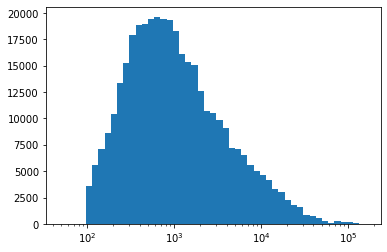

In [129]:
data = df_mobility['samples']
plt.hist(data, bins=np.logspace(np.log10(50),np.log10(df_mobility['samples'].max()), 50))
plt.xscale("log")

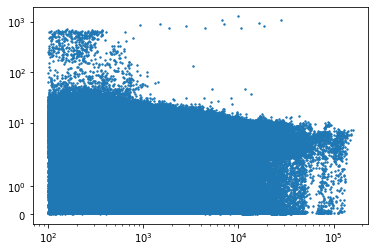

In [130]:
plt.scatter(df_mobility['samples'],df_mobility['m50'],s=2)
plt.xscale('log')
plt.yscale('symlog')

In [139]:
def run_model(df,name,task_type='GPU',max_depth= 6):
    remove_cols = ['date','fips', 'samples','COUNTY','m50_index', 'Lat', 'Lng','YEAR','NAME_E' ]
    target_var = ['m50']
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=target_var)
    y =df_final[target_var]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
    cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("Weekday"),X.columns.get_loc("party")]
    cb_model = catboost.CatBoostRegressor(task_type=task_type, n_estimators=1000, eval_metric='RMSE',
                                      max_depth=max_depth, learning_rate=0.3,verbose=200,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    print(np.round(r2_score(y_test,y_pred_cb),2))
    test = y_test.values.flatten()
    plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)
    plt.yscale('symlog')
    plt.xscale('log')
    plt.xlabel('y_true')
    plt.ylabel('Error (%)')
    plt.ylim(-500,500)
    plt.show()
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,y_test,y_pred_cb


0:	learn: 5.5110668	total: 72.7ms	remaining: 1m 12s
200:	learn: 1.6865476	total: 11.4s	remaining: 45.5s
400:	learn: 1.2557652	total: 22.7s	remaining: 33.9s
600:	learn: 1.0186578	total: 34s	remaining: 22.6s
800:	learn: 0.8473140	total: 45.4s	remaining: 11.3s
999:	learn: 0.7266098	total: 56.6s	remaining: 0us
0.86


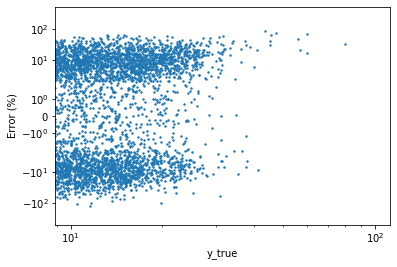

,Pre_Covid_Feature_Importance
Travel Time to Work_10 to 14 minutes,8.375389
Weekday,7.489471
STATE,6.818992
Travel Time to Work_5 to 9 minutes,3.066071
Travel Time to Work_15 to 19 minutes,2.982333
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,2.433135
Public Assistance Income or Food Stamps/SNAP in the Past 12 Months for Households_Total,2.256232
Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,2.139432
Race_White alone,2.127139
Race_Asian alone,1.913661


In [140]:
df_mob_train_pre = df_mob_train[df_mob_train.date < '2020-03-15']
df_mob_train_pre = df_mob_train_pre[df_mob_train_pre.m50<100]
df_mob_pre_feat_imp,y_test,y_pred_cb = run_model(df_mob_train_pre,name = 'Pre', task_type='CPU',max_depth = 7)
df_mob_pre_feat_imp.sort_values('Pre_Covid_Feature_Importance',ascending=False)[:25]

In [ ]:
y_test['error_pct'].hist(bins=100)

In [137]:
y_test['pred'] = y_pred_cb
y_test['error_pct'] = (y_test.m50 - y_test.pred)*100/y_test.m50
test_data = df_mob_train_pre.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], axis=1)

C:\Users\swami\Anaconda3\envs\sparkenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\swami\Anaconda3\envs\sparkenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,error_pct,Count
STATE,,
Alabama,0.558071,176
Alaska,-31.618718,3
Arizona,0.162519,46
Arkansas,-2.005157,200
California,0.447239,149
Colorado,-4.069224,127
Connecticut,3.951349,25
Delaware,4.971323,10
Florida,-0.688827,195


0:	learn: 4.7230339	total: 59.5ms	remaining: 59.4s
200:	learn: 1.9840926	total: 9.84s	remaining: 39.1s
400:	learn: 1.7375500	total: 19.7s	remaining: 29.4s
600:	learn: 1.5962213	total: 29.6s	remaining: 19.6s
800:	learn: 1.4845307	total: 39.5s	remaining: 9.82s
999:	learn: 1.3943220	total: 49.3s	remaining: 0us
0.86


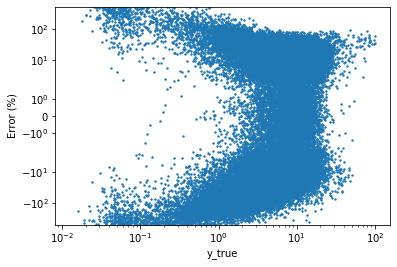

,Post_Covid_Feature_Importance
Weekday,7.587187
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,7.294621
Travel Time to Work_10 to 14 minutes,5.438042
case_rate,5.173670
STATE,4.528932
sunHour,3.560810
Travel Time to Work_5 to 9 minutes,2.618087
tempC,2.384777
pressure,2.156355
Ratio of Income to Poverty Level in the Past 12 Months_Total,1.870563


In [141]:
df_mob_train_covid = df_mob_train[df_mob_train.date >= '2020-03-15']
df_mob_train_covid = df_mob_train_covid[df_mob_train_covid.m50<100]
df_mob_covid_feat_imp,y_test,y_pred_cb = run_model(df_mob_train_covid,name='Post',max_depth = 8)
df_mob_covid_feat_imp.sort_values('Post_Covid_Feature_Importance',ascending=False)[:25]

In [170]:
y_test['pred'] = y_pred_cb
y_test['error_pct'] = (y_test.m50 - y_test.pred)*100/y_test.m50
test_data = df_mob_train_covid.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], axis=1)

C:\Users\swami\Anaconda3\envs\sparkenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\swami\Anaconda3\envs\sparkenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,error_pct,Count
STATE,,
Alabama,-0.644554,1662
Alaska,12.982993,14
Arizona,2.022244,345
Arkansas,-0.443114,1793
California,3.260234,1348
Colorado,1.082609,1059
Connecticut,2.937535,218
Delaware,-6.514824,78
Florida,-1.175319,1682


In [184]:
name_dict = df_county_demo.set_index('fips')['NAME_E'].to_dict()
def get_name(name_dict, x):
    if x in name_dict.keys():
        return name_dict[x]
    else:
        return None
df_mobility_rm['name'] = df_mobility_rm['fips'].apply(lambda x: get_name(name_dict, x))
df_mobility_rm[df_mobility_rm['m50']>500]

,fips,date,m50,rolling_mean_mob,name
125831,21127,2020-07-12,613.598,102.519286,"Lawrence County, Kentucky"
125833,21127,2020-07-14,853.026,224.495571,"Lawrence County, Kentucky"
125836,21127,2020-07-17,896.484,352.576857,"Lawrence County, Kentucky"
137768,22071,2020-07-14,1057.577,158.464286,"Orleans Parish, Louisiana"
137771,22071,2020-07-17,1271.363,339.756857,"Orleans Parish, Louisiana"
...,...,...,...,...,...
298833,48109,2020-06-28,509.295,428.424143,"Culberson County, Texas"
298836,48109,2020-07-01,580.579,403.269571,"Culberson County, Texas"
298847,48109,2020-07-12,579.356,408.418857,"Culberson County, Texas"
342095,51760,2020-07-14,757.470,133.105143,"Richmond city, Virginia"


In [22]:
# Creating a dataframe to record reduction in spending and mobility before and after covid
target_cols = ['rolling_mean_mob','spend_all']
covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
window = covid_date -datetime.timedelta(days=10)
df_covid = df_merged[df_merged.date>=window]
df_pre = df_merged[(df_merged.date<window)]
df_pre_mean = df_pre.groupby(['fips','date'])[target_cols].mean()

pre_covid_mean = df_pre_mean.groupby(level=[0])[target_cols].mean()
df_covid_mean = df_covid.groupby(['fips','date'])[target_cols].mean()


post_covid_min_date = df_covid_mean.groupby(level=[0])[target_cols].idxmin()
for col in target_cols:
    rename_col = 'min_date_' + col
    post_covid_min_date['min_date_'+col] = post_covid_min_date[col].str[1]
    post_covid_min_date = post_covid_min_date.drop(columns=[col])
post_covid_min = y.groupby(level=[0])[target_cols].min()
for col in target_cols:
    post_covid_min = post_covid_min.rename(columns={col:'Min_'+col})
df_mob_spend_red = pd.concat([pre_covid_mean,post_covid_min,post_covid_min_date],axis=1)

df_mob_spend_red = df_mob_spend_red.reset_index()
df_mob_spend_red = df_mob_spend_red.rename(columns={'index':'fips'})
for col in target_cols:
    min_date_col = 'min_date_' + col
    
    df_mob_spend_red['Drop_days_'+col] = (df_mob_spend_red[min_date_col] - covid_date).dt.days
    if col!='spend_all':
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((df_mob_spend_red[col] -df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])/df_mob_spend_red[col]
        df_mob_spend_red['Pct_Red_'+col] =( df_mob_spend_red[col] - df_mob_spend_red['Min_'+col])/df_mob_spend_red[col]
    else:
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((-1*df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])
        df_mob_spend_red['Pct_Red_'+col] = -1*df_mob_spend_red['Min_'+col]
df_mob_spend_red = df_mob_spend_red[df_mob_spend_red['Pct_Red_rolling_mean_mob']>=-0.5]
df_mob_spend_red.sample(5)

,fips,rolling_mean_mob,spend_all,Min_rolling_mean_mob,Min_spend_all,min_date_rolling_mean_mob,min_date_spend_all,Drop_days_rolling_mean_mob,Norm_Drop_Rate_rolling_mean_mob,Pct_Red_rolling_mean_mob,Drop_days_spend_all,Norm_Drop_Rate_spend_all,Pct_Red_spend_all
581,17117,8.280643,-0.039400,1.800571,-0.318,2020-03-28,2020-03-28,13.0,0.060197,0.782557,13.0,0.024462,0.318
60,01121,17.630429,-0.032879,4.720857,-0.236,2020-04-12,2020-03-29,28.0,0.026151,0.732232,14.0,0.016857,0.236
284,12023,6.964750,-0.032875,3.889286,-0.273,2020-04-19,2020-03-30,35.0,0.012616,0.441576,15.0,0.018200,0.273
89,04025,3.376964,0.015122,0.752714,-0.314,2020-04-13,2020-04-13,29.0,0.026797,0.777103,29.0,0.010828,0.314
326,12107,8.237857,-0.032957,3.531143,-0.194,2020-04-10,2020-03-29,26.0,0.021975,0.571352,14.0,0.013857,0.194


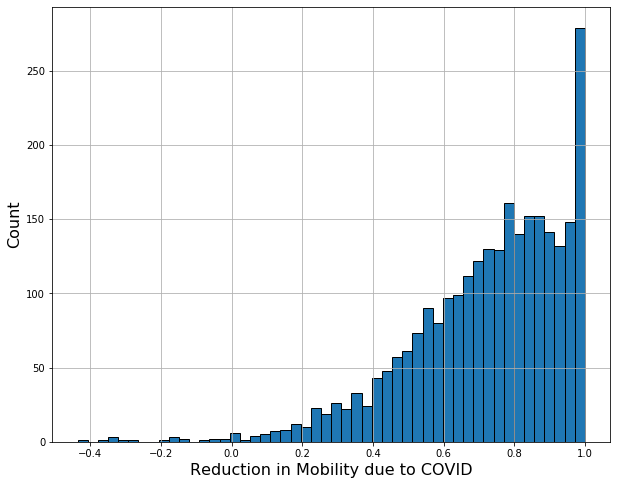

In [21]:
plt.figure(figsize=(10,8))
plt.rcParams["patch.force_edgecolor"] = True

df_mob_spend_red['Pct_Red_rolling_mean_mob'].hist(bins = 50)
plt.xlabel('Reduction in Mobility due to COVID', fontsize=16)
plt.ylabel('Count', fontsize = 16)
df_mob_spend_red['loc'] = df_mob_spend_red['fips'].apply(lambda x: get_county_state(county_dict,x))

In [47]:
df_mobility_index

,date,STATE,COUNTY,fips,samples,m50,m50_index
136,2020-03-01,Alabama,Autauga County,01001,1703,7.194,49
137,2020-03-02,Alabama,Autauga County,01001,1829,14.587,100
138,2020-03-03,Alabama,Autauga County,01001,1840,13.865,95
139,2020-03-04,Alabama,Autauga County,01001,1900,13.880,95
140,2020-03-05,Alabama,Autauga County,01001,1825,14.659,100
...,...,...,...,...,...,...,...
367134,2020-07-12,Wyoming,Uinta County,56041,756,24.010,766
367135,2020-07-13,Wyoming,Uinta County,56041,732,5.584,178
367136,2020-07-14,Wyoming,Uinta County,56041,651,5.035,160
367137,2020-07-15,Wyoming,Uinta County,56041,700,6.373,203


In [48]:
df_merged = pd.merge(left = df_mobility_index, right = df_covid_growth, on= ['COUNTY', 'STATE'],how='left')
df_merged['growthFactor'] = df_merged['growthFactor'].fillna(df_merged['growthFactor'].mean() )
df_merged.corr()

,samples,m50,m50_index,growthFactor
samples,1.000000,-0.069507,-0.045263,0.077986
m50,-0.069507,1.000000,0.279804,-0.014436
m50_index,-0.045263,0.279804,1.000000,-0.020126
growthFactor,0.077986,-0.014436,-0.020126,1.000000


In [165]:
X_train

,STATE,Drop_days,growthFactor,Sex by Age_Total,Sex by Age_Male,Sex by Age_Male Under 5 years,Sex by Age_Male 5 to 9 years,Sex by Age_Male 10 to 14 years,Sex by Age_Male 15 to 17 years,Sex by Age_Male 18 and 19 years,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_10.0 to 14.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_15.0 to 19.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,AKGVE001
2205,Kentucky,17,1.024478,8637,0.490680,0.028019,0.029293,0.034850,0.022577,0.017483,...,0.187852,0.077615,0.057368,0.039370,0.042745,0.109111,0.075366,0.146232,0.209224,0.4569
940,North Carolina,29,1.062903,130361,0.495348,0.038877,0.038171,0.038762,0.021072,0.013578,...,0.083765,0.129864,0.119495,0.112499,0.080705,0.049097,0.105628,0.185833,0.108189,0.4177
1815,Iowa,31,1.077123,25039,0.490754,0.029115,0.036303,0.039179,0.021606,0.013140,...,0.168367,0.131725,0.115955,0.114100,0.040816,0.038961,0.059369,0.103432,0.140538,0.3995
219,New York,30,1.027273,194402,0.491806,0.027093,0.029166,0.026363,0.018379,0.022273,...,0.089669,0.098801,0.091979,0.096784,0.072138,0.063300,0.071955,0.285070,0.082297,0.4591
445,North Carolina,22,1.023947,10813,0.473967,0.017294,0.031629,0.027189,0.009711,0.006936,...,0.117647,0.067109,0.167357,0.128418,0.019056,0.064623,0.004143,0.176471,0.226181,0.4871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,Georgia,25,1.070217,106497,0.475112,0.033747,0.039738,0.037316,0.025926,0.016498,...,0.075733,0.112078,0.094159,0.106584,0.081819,0.061702,0.090102,0.272082,0.057561,0.4384
1095,Idaho,17,1.010000,27969,0.511102,0.049233,0.051092,0.047088,0.030069,0.016483,...,0.129693,0.104664,0.233788,0.030717,0.035267,0.034130,0.036974,0.090444,0.153584,0.3723
1130,Kentucky,22,1.017534,22843,0.490303,0.031738,0.037473,0.024778,0.019700,0.010725,...,0.059140,0.069479,0.048801,0.102151,0.094706,0.083954,0.047560,0.188172,0.250620,0.4966
1294,New York,38,0.859362,26719,0.503425,0.029941,0.032000,0.034657,0.019574,0.010517,...,0.087283,0.089629,0.076959,0.083998,0.092445,0.054435,0.063820,0.265603,0.111685,0.4126


In [194]:
import shap

from catboost import Pool
plt.rcParams['font.size'] = 12
plt.rc('xtick', labelsize=10)
shap_values = cb_model.get_feature_importance(Pool(X_train, label=y_train),
                                               fstr_type="ShapValues",shap_calc_type='Approximate')
shap_values = shap_values[:, :-1]

title = "SHAP Value - CatBoost:COVID"
plt.title(title)
shap.summary_plot(shap_values, X_train, show=True)

TypeError: an integer is required (got type bytes)

In [46]:
top10_pop = df_all.groupby(['STATE'])['Sex by Age_Total'].mean().sort_values(ascending=False).index[:10]

def filter_df(x):
    if x in top10_pop:
        return x
    else:
        return None
df_all_fil = df_all.copy()

df_all_fil['STATE'] = df_all_fil['STATE'].apply(lambda x: filter_df(x))
df_all_fil = df_all_fil.dropna()


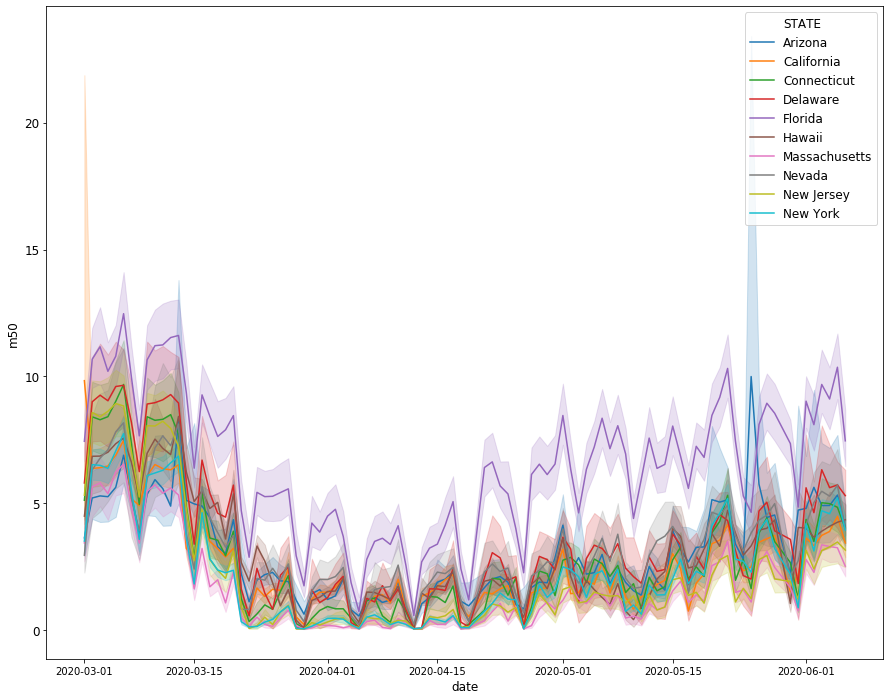

In [47]:
plt.figure(figsize=(15,12))
sns.lineplot(x='date', y = 'm50', hue='STATE', data=df_all_fil)